In [10]:
import torch
import torch.nn as nn

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 


In [11]:
df = pd.read_csv('../PYTORCH_NOTEBOOKS/Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [12]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [13]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [14]:
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude' )
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['NYC_Time'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['Hour'] = df['NYC_Time'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12, 'AM', 'PM')
df['Week day'] = df['NYC_Time'].dt.strftime("%a")
df.head()

In [ ]:
df.columns

In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Week day']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

y_col = ['fare_amount']

for cat in cat_cols:
    df[cat] = df[cat].astype('category')

df.dtypes

In [18]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [19]:
hr = df['Hour'].cat.codes.values
wkdy = df['Week day'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], axis=1)
cats = torch.tensor(cats, dtype=torch.int64)

conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)

y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y.shape


torch.Size([120000, 1])

In [20]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [21]:
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [22]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [23]:
embeddingz = []

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:, i]))

In [24]:
z = torch.cat(embeddingz, 1)
z

tensor([[-1.1712, -1.0707,  1.5110, -1.4429, -0.3396, -1.6925, -0.3451,  1.3243,
          0.1380, -0.7729,  0.9246,  0.5713, -0.0216,  0.4373, -0.7895,  1.2179,
          0.4470],
        [ 0.4214,  0.9682, -0.9452,  1.9558,  0.9899,  1.0497,  1.0668, -1.0889,
         -1.4327, -2.1288, -0.0278, -0.6627, -0.0216,  1.6881, -1.5008, -1.5567,
          0.5621],
        [ 1.8679, -0.2671,  0.0272, -1.2297, -0.7697, -0.0064,  0.7389, -1.3731,
         -0.6959, -1.0619, -0.4985, -1.1778, -0.0216,  1.6881, -1.5008, -1.5567,
          0.5621],
        [-0.3787, -2.2401, -1.1068, -1.3562,  0.1844,  0.5235, -1.7119, -0.2419,
         -0.8690, -0.5548, -0.4396,  1.4136,  0.3949,  0.6990, -0.1895, -2.1106,
         -1.7561]], grad_fn=<CatBackward>)

In [25]:
selfembdrop = nn.Dropout(0.4)
z = selfembdrop(z)
z

tensor([[-1.9521, -1.7846,  0.0000, -2.4048, -0.0000, -2.8208, -0.0000,  0.0000,
          0.2299, -1.2882,  0.0000,  0.0000, -0.0000,  0.7289, -0.0000,  2.0298,
          0.7450],
        [ 0.7023,  0.0000, -0.0000,  3.2596,  1.6499,  1.7495,  0.0000, -1.8149,
         -0.0000, -3.5480, -0.0000, -1.1045, -0.0359,  0.0000, -0.0000, -2.5945,
          0.0000],
        [ 0.0000, -0.0000,  0.0453, -0.0000, -1.2829, -0.0000,  1.2315, -2.2886,
         -1.1599, -1.7698, -0.0000, -1.9630, -0.0359,  2.8135, -0.0000, -2.5945,
          0.0000],
        [-0.6312, -3.7335, -1.8447, -2.2604,  0.0000,  0.8725, -2.8532, -0.0000,
         -1.4483, -0.9247, -0.0000,  0.0000,  0.0000,  1.1650, -0.0000, -3.5177,
         -2.9269]], grad_fn=<MulBackward0>)

In [31]:
class TabularModel(nn.Module):
    def __init__(self, emb_szss, n_cont, out_szs, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layers_list = []
        n_emb = sum([nf for ni, nf in emb_szs])
        n_in = n_emb + n_cont
        
        for i in layers:
            layers_list.append(nn.Linear(n_in, i))
            layers_list.append(nn.ReLU(inplace=True))
            layers_list.append(nn.BatchNorm1d(i))
            layers_list.append(nn.Dropout(p))
            n_in = i
        layers_list.append(nn.Linear(layers[-1], out_szs))
        self.layers = nn.Sequential(*layers_list)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [32]:
torch.manual_seed(33)
Model = TabularModel(emb_szs, conts.shape[1], 1, [300, 200], p=0.4)
Model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)

In [34]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [35]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = Model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.50505733
epoch:  26  loss: 10.42066288
epoch:  51  loss: 10.01141167
epoch:  76  loss: 9.43966007
epoch: 101  loss: 8.44072819
epoch: 126  loss: 6.85758638
epoch: 151  loss: 5.04473495
epoch: 176  loss: 3.95244169
epoch: 201  loss: 3.76425862
epoch: 226  loss: 3.65732360
epoch: 251  loss: 3.58557343
epoch: 276  loss: 3.52457261
epoch: 300  loss: 3.48172164

Duration: 652 seconds


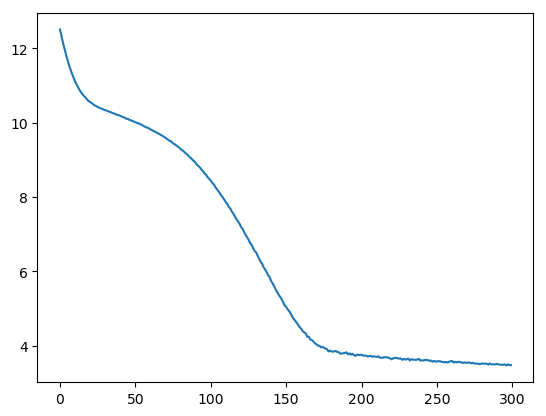

In [37]:
plt.plot(range(epochs), losses)

In [42]:
with torch.no_grad():
    y_val = Model(cat_test, con_test)
    
    loss = torch.sqrt(criterion(y_val, y_test))
    print(loss)

tensor(3.3838)


In [43]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   3.7482   2.9000   0.8482
 2.  22.1965   5.7000  16.4965
 3.   7.6642   7.7000   0.0358
 4.  14.2362  12.5000   1.7362
 5.   5.7594   4.1000   1.6594
 6.   5.3384   5.3000   0.0384
 7.   7.4922   3.7000   3.7922
 8.  18.6559  14.5000   4.1559
 9.   4.1061   5.7000   1.5939
10.  11.5917  10.1000   1.4917
11.   5.5143   4.5000   1.0143
12.   5.0289   6.1000   1.0711
13.   5.8389   6.9000   1.0611
14.  12.9265  14.1000   1.1735
15.   6.9389   4.5000   2.4389
16.  32.9811  34.1000   1.1189
17.   1.0182  12.5000  11.4818
18.   4.5624   4.1000   0.4624
19.   7.7452   8.5000   0.7548
20.   4.8720   5.3000   0.4280
21.  12.7850  11.3000   1.4850
22.  10.6229  10.5000   0.1229
23.  15.8301  15.3000   0.5301
24.  15.8911  14.9000   0.9911
25.  51.0244  49.5700   1.4544
26.   4.8163   5.3000   0.4837
27.   4.6539   3.7000   0.9539
28.   7.4667   6.5000   0.9667
29.  13.5111  14.1000   0.5889
30.   4.1392   4.9000   0.7608
31.   4.1826   3.7000   0.4826
32.  33.

In [48]:
if len(losses) == epochs:
    torch.save(Model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Modelo ainda não treinado.')